# import libraries

In [1]:
import numpy as np # standard library for array processing
import pandas as pd # standard library for deal with csv, excel and dataframe
import nltk # natural langauge processing toolkit for deal with  natural langauge 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re # for string and expression
from sklearn.model_selection import train_test_split # for split data
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # convert language to machine understand langauge 
import h2o # machine learning library for auto finding best parameters and machine learning algorithm
from h2o.automl import H2OAutoML 
from matplotlib import pyplot as plt 

In [2]:
df = pd.read_excel('HealthStoryCSVFileContainingAllData.xlsx') # read the data and save in df 
df.head() # display some data

,link,title,description,original_title,rating,reviewers,category,tags,source_link,summary,...,Unnamed: 4401,Unnamed: 4402,Unnamed: 4403,Unnamed: 4404,Unnamed: 4405,Unnamed: 4406,Unnamed: 4407,Unnamed: 4408,Unnamed: 4409,Unnamed: 4410
0,https://www.healthnewsreview.org/review/guardi...,Guardian jumps to conclusions about an Alzheim...,The storyâ€™s headline states: â€œVirtual real...,Virtual reality to help detect early risk of A...,1,"['Matt Shipman', 'Doug Campos-Outcalt, MD, MPA...",The Guardian,"[""alzheimer's disease""]",https://www.theguardian.com/society/2018/dec/1...,{'Our Review Summary': 'The story focuses on a...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.healthnewsreview.org/review/in-sto...,"In story on experimental contraceptive gel, Re...",This leaves both investors and lay audiences w...,Evofem's birth control gel meets main study go...,3,"['Jill U. Adams', 'Susan Molchan, MD, MA', 'Jo...",Reuters,['contraceptives'],https://www.reuters.com/article/us-evofem-stud...,{'Our Review Summary': 'Reuters reports on a n...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.healthnewsreview.org/review/using-...,"Using a single patient anecdote, ABC News hail...",Breakthrough? Based on the story of one patien...,How a breakthrough new fertility test is offer...,2,"['Gary Schwitzer', 'Karen Carlson, MD', 'Joy V...",ABC News,['infertility'],https://abcnews.go.com/GMA/Wellness/breakthrou...,{'Our Review Summary': 'ABC News pursues a sto...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.healthnewsreview.org/review/hard-t...,Hard to find the journalism in this brief Reut...,The story mostly just rehashes a drug company ...,J&J says its psoriasis drug superior to Novart...,2,"['Michael Joyce, MD', 'Ishani Ganguli, MD, MPH...",Reuters,['Psoriasis'],https://www.reuters.com/article/us-j-j-drug-ps...,{'Our Review Summary': 'This is a brief news s...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.healthnewsreview.org/review/a-litt...,A little more context would have boosted alrea...,Did the study findings really earn a label of ...,Incontinence Drug May Cut Hot Flashes in Brea...,5,"['Sue Rochman', 'Karen Carlson, MD', 'Joy Vict...",HealthDay,"['breast cancer', 'hot flashes']",https://consumer.healthday.com/women-s-health-...,{'Our Review Summary': 'The San Antonio Breast...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# there is a lot of columns so we pick only our target columns
df_ = df[['text','Q6']].copy()

In [4]:
# Drop the empty text column rows
df_.dropna(subset=['text'], inplace=True)

In [5]:
# check the nan values in text
df_['text'].isna().sum()

0

# clean the data 

we define functions for clean the text

In [6]:
def list_to_remove_words_less_then_3(text):
    text = text.split()
    text = " ".join([word for word in text if len(word)>2])
    return text

In [7]:
stop_words = stopwords.words('english')
def nltk_stopword(text, stpwrd=stop_words):
    text = text.split()
    text = " ".join([word.lower() for word in text if not word in stpwrd])
    
    return text

In [8]:
ps = PorterStemmer()
def stemming_func(text):
    text = text.split()
    text = " ".join([ps.stem(word) for word in text])
    
    return text

In [9]:
nltk.download("punkt")
def remove_punc(text):
    text = text.split()
    text = " ".join([word for word in text if word.isalnum()])
    
    return text

[nltk_data] Downloading package punkt to /home/ushah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
df_['text'] = df_['text'].map(lambda x: str(x))
df_['text'] = df_['text'].apply(list_to_remove_words_less_then_3)
df_['text'] = df_['text'].apply(nltk_stopword)
df_['text'] = df_['text'].apply(remove_punc)
df_['text'] = df_['text'].apply(stemming_func)

### Apply the functions to clean the text 

In [11]:
df_ = df_[df_['Q6'].isin(['Not Satisfactory', 'Satisfactory', 'Not Applicable'])]

<AxesSubplot:>

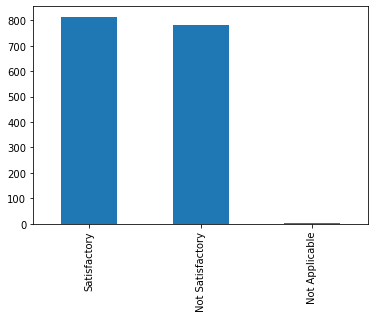

In [12]:
df_.Q6.value_counts().plot(kind='bar')

In [13]:
# one-hot encoding for target column
encoding = {'Not Satisfactory': 0,
            'Not Applicable': 0,
            'Satisfactory': 1,
           }

labels = ['Not Satisfactory', 'Satisfactory']
           

df_['Q6'].replace(encoding, inplace=True)

In [14]:
df_.dropna(subset = ["text"], inplace=True)
df_.text.isna().sum()

0

# CountVectorizer

In [15]:
# Transform each text into a vector of word counts
vectorizer = CountVectorizer(max_features=2000, max_df = 0.75, 
                             input=df_['text'].all(),
                            ngram_range=(1,2))

training_features = vectorizer.fit_transform(df_['text']) 

In [16]:
x_train, x_test, y_train, y_test = train_test_split(training_features.A, df_['Q6'], test_size = 0.15, 
                                                    random_state = 101, stratify=df_.Q6)

# linear_model

In [17]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import sklearn
alpha = [80.0, 90.0, 100.0, 110.0, 120.0] 
for a in alpha:
    ridge = linear_model.RidgeClassifier(a)
    scores = sklearn.model_selection.cross_val_score(ridge, x_train, y_train, cv=5)#scoring='f1' kaldirdim multiclass hatasina karsilik
    print("alpha: ",a)
    print(scores)
    print(np.mean(scores))
    print('\n')

alpha:  80.0
[0.58823529 0.59191176 0.67279412 0.62132353 0.65808824]
0.6264705882352942


alpha:  90.0
[0.58823529 0.59926471 0.67647059 0.62132353 0.67279412]
0.6316176470588235


alpha:  100.0
[0.58823529 0.58823529 0.67647059 0.63602941 0.66911765]
0.6316176470588235


alpha:  110.0
[0.58823529 0.59191176 0.67647059 0.63970588 0.66544118]
0.6323529411764706


alpha:  120.0
[0.58823529 0.60661765 0.67279412 0.63970588 0.66544118]
0.6345588235294117




# naive_bayes

In [18]:
# MultinomialNB with bag of word
from sklearn.naive_bayes import MultinomialNB
alpha = [1e-10, 1e-5, 0.1, 1.0, 2.0, 5.0]
for a in alpha:
    mnb = MultinomialNB(a)
    scores = sklearn.model_selection.cross_val_score(mnb, x_train, y_train, cv=5)
    print('alpha: ', a)
    print(scores)
    print(np.mean(scores))
    print('\n')

alpha:  1e-10
[0.58823529 0.56617647 0.65441176 0.56985294 0.55882353]
0.5875


alpha:  1e-05
[0.58823529 0.56617647 0.65441176 0.56985294 0.55882353]
0.5875


alpha:  0.1
[0.58823529 0.56985294 0.65073529 0.57720588 0.55882353]
0.5889705882352942


alpha:  1.0
[0.58088235 0.56985294 0.65073529 0.58088235 0.55882353]
0.5882352941176471


alpha:  2.0
[0.58455882 0.56617647 0.64338235 0.58823529 0.55882353]
0.5882352941176471


alpha:  5.0
[0.58088235 0.55514706 0.66544118 0.59558824 0.56617647]
0.5926470588235295




# DecisionTreeClassifier

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dtclassifier=DecisionTreeClassifier(criterion="entropy", max_depth=None)
dtclassifier.fit(x_train,y_train)
preddt = dtclassifier.predict(x_test)
accuracy= accuracy_score(preddt,y_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, preddt))
print(confusion_matrix(y_test, preddt))

              precision    recall  f1-score   support

           0       0.54      0.62      0.57       118
           1       0.57      0.49      0.53       123

    accuracy                           0.55       241
   macro avg       0.55      0.55      0.55       241
weighted avg       0.55      0.55      0.55       241

[[73 45]
 [63 60]]


# SVM

In [20]:
# Perform classification with SVM, kernel=linear
import time
from sklearn import svm
from sklearn.metrics import classification_report
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(x_train, y_train)
prediction_linear = classifier_linear.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.56      0.62      0.59       118
           1       0.59      0.54      0.56       123

    accuracy                           0.58       241
   macro avg       0.58      0.58      0.58       241
weighted avg       0.58      0.58      0.58       241

[[73 45]
 [57 66]]


# LogisticRegression

In [21]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='lbfgs', multi_class="ovr")
log_reg.fit(x_train, y_train)
prediction_linear = log_reg.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

/home/ushah/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.58      0.68      0.63       118
           1       0.63      0.54      0.58       123

    accuracy                           0.61       241
   macro avg       0.61      0.61      0.60       241
weighted avg       0.61      0.61      0.60       241

[[80 38]
 [57 66]]


# RandomForestClassifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
rnf = RandomForestClassifier(n_estimators=200)
rnf.fit(x_train, y_train)
prediction_linear = rnf.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65       118
           1       0.66      0.72      0.69       123

    accuracy                           0.67       241
   macro avg       0.67      0.67      0.67       241
weighted avg       0.67      0.67      0.67       241

[[73 45]
 [35 88]]


# GradientBoostingClassifier

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=400, random_state = 2020)
gbc.fit(x_train, y_train)
prediction_linear = gbc.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       118
           1       0.66      0.63      0.64       123

    accuracy                           0.64       241
   macro avg       0.64      0.64      0.64       241
weighted avg       0.64      0.64      0.64       241

[[77 41]
 [45 78]]


# HistGradientBoostingClassifier

In [24]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
hgbc = HistGradientBoostingClassifier()
hgbc.fit(x_train, y_train)
prediction_linear = hgbc.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.61      0.65      0.63       118
           1       0.64      0.60      0.62       123

    accuracy                           0.63       241
   macro avg       0.63      0.63      0.63       241
weighted avg       0.63      0.63      0.63       241

[[77 41]
 [49 74]]


# Apply MinMaxScaler on countvectories

In [25]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_train = min_max_scaler.fit_transform(x_train)
x_test = min_max_scaler.fit_transform(x_test)

# linear_model

In [26]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import sklearn
alpha = [80.0, 90.0, 100.0, 110.0, 120.0] 
for a in alpha:
    ridge = linear_model.RidgeClassifier(a)
    scores = sklearn.model_selection.cross_val_score(ridge, x_train, y_train, cv=5)#scoring='f1' kaldirdim multiclass hatasina karsilik
    print("alpha: ",a)
    print(scores)
    print(np.mean(scores))
    print('\n')

alpha:  80.0
[0.67279412 0.68014706 0.67647059 0.63602941 0.69117647]
0.6713235294117647


alpha:  90.0
[0.66911765 0.68382353 0.67279412 0.63970588 0.69117647]
0.6713235294117647


alpha:  100.0
[0.66911765 0.68014706 0.66176471 0.64338235 0.6875    ]
0.6683823529411764


alpha:  110.0
[0.66544118 0.68014706 0.68014706 0.65073529 0.6875    ]
0.6727941176470589


alpha:  120.0
[0.66911765 0.68014706 0.67647059 0.64705882 0.69117647]
0.6727941176470587




# naive_bayes

In [27]:
# MultinomialNB with bag of word
from sklearn.naive_bayes import MultinomialNB
alpha = [1e-10, 1e-5, 0.1, 1.0, 2.0, 5.0]
for a in alpha:
    mnb = MultinomialNB(a)
    scores = sklearn.model_selection.cross_val_score(mnb, x_train, y_train, cv=5)
    print('alpha: ', a)
    print(scores)
    print(np.mean(scores))
    print('\n')

alpha:  1e-10
[0.60294118 0.59926471 0.64705882 0.63602941 0.60661765]
0.6183823529411765


alpha:  1e-05
[0.60294118 0.59926471 0.64705882 0.63602941 0.60661765]
0.6183823529411765


alpha:  0.1
[0.59926471 0.59926471 0.64705882 0.625      0.59558824]
0.6132352941176471


alpha:  1.0
[0.61029412 0.59191176 0.63602941 0.60294118 0.60294118]
0.6088235294117647


alpha:  2.0
[0.59558824 0.60294118 0.63235294 0.60294118 0.59926471]
0.6066176470588235


alpha:  5.0
[0.59191176 0.61029412 0.66176471 0.60661765 0.60294118]
0.6147058823529411




# DecisionTreeClassifier

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dtclassifier=DecisionTreeClassifier(criterion="entropy", max_depth=None)
dtclassifier.fit(x_train,y_train)
preddt = dtclassifier.predict(x_test)
accuracy= accuracy_score(preddt,y_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, preddt))
print(confusion_matrix(y_test, preddt))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53       118
           1       0.55      0.56      0.56       123

    accuracy                           0.54       241
   macro avg       0.54      0.54      0.54       241
weighted avg       0.54      0.54      0.54       241

[[62 56]
 [54 69]]


# SVM

In [29]:
# Perform classification with SVM, kernel=linear
import time
from sklearn import svm
from sklearn.metrics import classification_report
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(x_train, y_train)
prediction_linear = classifier_linear.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.53      0.49      0.51       118
           1       0.55      0.59      0.56       123

    accuracy                           0.54       241
   macro avg       0.54      0.54      0.54       241
weighted avg       0.54      0.54      0.54       241

[[58 60]
 [51 72]]


# LogisticRegression

In [30]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='lbfgs', multi_class="ovr")
log_reg.fit(x_train, y_train)
prediction_linear = log_reg.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.57      0.50      0.53       118
           1       0.57      0.63      0.60       123

    accuracy                           0.57       241
   macro avg       0.57      0.57      0.57       241
weighted avg       0.57      0.57      0.57       241

[[59 59]
 [45 78]]


# RandomForestClassifier

In [31]:
from sklearn.ensemble import RandomForestClassifier
rnf = RandomForestClassifier(n_estimators=400, random_state = 2020)
rnf.fit(x_train, y_train)
prediction_linear = rnf.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.66      0.42      0.52       118
           1       0.59      0.79      0.67       123

    accuracy                           0.61       241
   macro avg       0.62      0.61      0.59       241
weighted avg       0.62      0.61      0.60       241

[[50 68]
 [26 97]]


# GradientBoostingClassifier

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=400, random_state = 2020)
gbc.fit(x_train, y_train)
prediction_linear = gbc.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.62      0.67      0.64       118
           1       0.66      0.61      0.63       123

    accuracy                           0.64       241
   macro avg       0.64      0.64      0.64       241
weighted avg       0.64      0.64      0.64       241

[[79 39]
 [48 75]]


# HistGradientBoostingClassifier

In [33]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
hgbc = HistGradientBoostingClassifier()
hgbc.fit(x_train, y_train)
prediction_linear = hgbc.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.64      0.66      0.65       118
           1       0.67      0.65      0.66       123

    accuracy                           0.66       241
   macro avg       0.66      0.66      0.66       241
weighted avg       0.66      0.66      0.66       241

[[78 40]
 [43 80]]


# TfidfVectorizer

In [34]:
# Transform each text into a vector of word counts
vectorizer1 = TfidfVectorizer(max_features=2000, max_df = 0.75, 
                             input=df_['text'].all(),
                            ngram_range=(1,2))

training_features = vectorizer1.fit_transform(df_['text']) 

In [35]:
x_train, x_test, y_train, y_test = train_test_split(training_features.A, df_['Q6'], test_size = 0.15, 
                                                    random_state = 101, stratify=df_.Q6)

# linear_model

In [36]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import sklearn
alpha = [80.0, 90.0, 100.0, 110.0, 120.0] 
for a in alpha:
    ridge = linear_model.RidgeClassifier(a)
    scores = sklearn.model_selection.cross_val_score(ridge, x_train, y_train, cv=5)#scoring='f1' kaldirdim multiclass hatasina karsilik
    print("alpha: ",a)
    print(scores)
    print(np.mean(scores))
    print('\n')

alpha:  80.0
[0.54779412 0.61029412 0.62132353 0.54411765 0.56617647]
0.5779411764705882


alpha:  90.0
[0.55882353 0.59191176 0.60661765 0.54411765 0.56617647]
0.5735294117647058


alpha:  100.0
[0.55514706 0.58823529 0.58455882 0.54779412 0.55882353]
0.5669117647058824


alpha:  110.0
[0.51838235 0.58088235 0.57720588 0.54779412 0.55147059]
0.5551470588235295


alpha:  120.0
[0.51838235 0.57720588 0.57720588 0.55147059 0.5625    ]
0.5573529411764706




# MultinomialNB

In [37]:
# MultinomialNB with bag of word
from sklearn.naive_bayes import MultinomialNB
alpha = [1e-10, 1e-5, 0.1, 1.0, 2.0, 5.0]
for a in alpha:
    mnb = MultinomialNB(a)
    scores = sklearn.model_selection.cross_val_score(mnb, x_train, y_train, cv=5)
    print('alpha: ', a)
    print(scores)
    print(np.mean(scores))
    print('\n')

alpha:  1e-10
[0.58088235 0.59926471 0.63235294 0.55882353 0.55147059]
0.5845588235294118


alpha:  1e-05
[0.58088235 0.59926471 0.63235294 0.55882353 0.55147059]
0.5845588235294118


alpha:  0.1
[0.58088235 0.59926471 0.63235294 0.5625     0.54044118]
0.5830882352941177


alpha:  1.0
[0.58088235 0.59926471 0.63602941 0.57720588 0.55147059]
0.5889705882352942


alpha:  2.0
[0.55882353 0.58823529 0.63602941 0.57352941 0.55147059]
0.5816176470588236


alpha:  5.0
[0.54779412 0.60661765 0.63970588 0.57720588 0.54411765]
0.5830882352941176




# DecisionTreeClassifier

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dtclassifier=DecisionTreeClassifier(criterion="entropy", max_depth=None)
dtclassifier.fit(x_train,y_train)
preddt = dtclassifier.predict(x_test)
accuracy= accuracy_score(preddt,y_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, preddt))
print(confusion_matrix(y_test, preddt))

              precision    recall  f1-score   support

           0       0.50      0.58      0.54       118
           1       0.52      0.45      0.48       123

    accuracy                           0.51       241
   macro avg       0.51      0.51      0.51       241
weighted avg       0.51      0.51      0.51       241

[[68 50]
 [68 55]]


# SVM

In [39]:
# Perform classification with SVM, kernel=linear
import time
from sklearn import svm
from sklearn.metrics import classification_report
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(x_train, y_train)
prediction_linear = classifier_linear.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.57      0.58      0.57       118
           1       0.59      0.59      0.59       123

    accuracy                           0.58       241
   macro avg       0.58      0.58      0.58       241
weighted avg       0.58      0.58      0.58       241

[[68 50]
 [51 72]]


# LogisticRegression

In [40]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='lbfgs', multi_class="ovr")
log_reg.fit(x_train, y_train)
prediction_linear = log_reg.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.56      0.58      0.57       118
           1       0.58      0.56      0.57       123

    accuracy                           0.57       241
   macro avg       0.57      0.57      0.57       241
weighted avg       0.57      0.57      0.57       241

[[68 50]
 [54 69]]


# RandomForestClassifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
rnf = RandomForestClassifier(n_estimators=400, random_state = 2020)
rnf.fit(x_train, y_train)
prediction_linear = rnf.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.61      0.60      0.60       118
           1       0.62      0.63      0.62       123

    accuracy                           0.61       241
   macro avg       0.61      0.61      0.61       241
weighted avg       0.61      0.61      0.61       241

[[71 47]
 [46 77]]


# GradientBoostingClassifier

In [42]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=400, random_state = 2020)
gbc.fit(x_train, y_train)
prediction_linear = gbc.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.62      0.60      0.61       118
           1       0.63      0.64      0.63       123

    accuracy                           0.62       241
   macro avg       0.62      0.62      0.62       241
weighted avg       0.62      0.62      0.62       241

[[71 47]
 [44 79]]


# HistGradientBoostingClassifier

In [43]:
from sklearn.ensemble import HistGradientBoostingClassifier
gbc = HistGradientBoostingClassifier()
gbc.fit(x_train, y_train)
prediction_linear = gbc.predict(x_test)
print(classification_report(y_test, prediction_linear))
print(confusion_matrix(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       118
           1       0.63      0.63      0.63       123

    accuracy                           0.63       241
   macro avg       0.63      0.63      0.63       241
weighted avg       0.63      0.63      0.63       241

[[73 45]
 [45 78]]
